In [35]:
import pretty_midi
from note import Note, MIDI_note
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, Dataset
import torch

def extract_midi(path):
    mid = pretty_midi.PrettyMIDI(midi_file=path)
    tempo_times, tempo_bpm = mid.get_tempo_changes()
    end_time = mid.get_end_time()
    tempo_times = np.append(tempo_times, end_time)

    midi_notes = []
    for inst in mid.instruments:
        channel = inst.program
        for n in inst.notes:
            midi_notes.append(MIDI_note(pitch=n.pitch, time_start=n.start, time_end=n.end, dynamic=n.velocity, channel=channel))

    midi_notes = list(set(midi_notes))
    midi_notes = sorted(midi_notes, key=lambda note: note.time_start)

    return midi_notes, tempo_times, tempo_bpm

def get_beats_and_tempo(tempo_times, tempo_bpm):
    res_per_beat = 12
    resolutions = []
    total_beats = [0]

    for idx, val in enumerate(tempo_times[:-1]):
        beat_length = 60 / tempo_bpm[idx]
        resolution = beat_length / res_per_beat
        resolutions.append(resolution)
        
        num_beats = round((tempo_times[idx + 1] - val) / resolution)
        total_beats.append(num_beats + total_beats[idx])

    # Convert lists to NumPy arrays
    resolutions = np.array(resolutions)
    total_beats = np.array(total_beats)
    return resolutions, total_beats

def adjust_note_time(midi_notes, tempo_times, resolutions, total_beats, attribute):
    for n in midi_notes:
        idx = 0  # Reset idx for each note
        while idx < len(tempo_times) - 1:
            if tempo_times[idx] <= getattr(n, attribute) < tempo_times[idx + 1]:
                ticks = (getattr(n, attribute) - tempo_times[idx]) / resolutions[idx]
                setattr(n, attribute, np.round(total_beats[idx] + ticks))
                break
            elif idx < len(tempo_times) - 2:
                idx += 1
            else:
                break

def create_canvas(midi_notes, tempo_bpm, total_beats):
    # Assume tempo_times and tempo_bpm are defined
    largest_time_end = int(max(note.time_end for note in midi_notes))
    song_canvas = np.zeros((4, 128, largest_time_end), dtype=float)  # Use dtype=float for flexibility

    for n in midi_notes:
        # Find the appropriate tempo index for n.time_start
        idx = next((i for i, t in enumerate(tempo_bpm[:-1]) if total_beats[i] <= n.time_start < total_beats[i + 1]), None)
        
        if idx is not None:
            tempo = tempo_bpm[idx]
            start = int(n.time_start)  # Convert time_start to integer
            end = int(n.time_end)  # Convert time_end to integer

            # Ensure indices are within the bounds of the canvas
            if end > largest_time_end:
                end = largest_time_end

            # Fill the song_canvas with the respective values
            song_canvas[0, n.pitch, start:end] = (n.channel + 1)
            song_canvas[1, n.pitch, start:end] = n.dynamic
            song_canvas[2, n.pitch, start] = 1  # Mark note start
            song_canvas[3, n.pitch, start:end] = tempo

    return song_canvas

def show_canvas(song_canvas, feature_idx, pitch_bounds=None, time_bounds=None):
    if time_bounds is not None:
        lower_bound, upper_bound = time_bounds
        array_2d = np.flipud(song_canvas[feature_idx].squeeze()[:, lower_bound:upper_bound])  # Shape becomes (128, 1000) with pitch flipped
    else:
        array_2d = np.flipud(song_canvas[feature_idx].squeeze()[:, :])  # Shape becomes (128, 1000) with pitch flipped

    if pitch_bounds is not None:
        lower_bound, upper_bound = pitch_bounds
        array_2d = array_2d.squeeze()[lower_bound:upper_bound, :]  # Shape becomes (128, 1000) with pitch flipped
    else:
        array_2d = array_2d.squeeze()[:, :]  # Shape becomes (128, 1000) with pitch flipped

    # Set the minimum value to 0 and normalize to the range [0, 1] for visualization
    array_2d = (array_2d - np.min(array_2d)) / (np.max(array_2d) - np.min(array_2d))

    # Create a custom colormap with black for 0 and bright colors for higher values
    from matplotlib.colors import LinearSegmentedColormap
    custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [(0, "black"), (1 / 128, "blue"), (1, "yellow")])

    # Visualize the array as an image
    plt.figure(figsize=(15, 5))  # Adjust figure size for large dimensions
    plt.imshow(array_2d, aspect='auto', cmap=custom_cmap)  # Display the image with a custom colormap
    plt.colorbar(label='Normalized Value')  # Add colorbar
    plt.xlabel('Time')
    plt.ylabel('Pitch')
    plt.title('Song Canvas Visualization with Enhanced Contrast')
    plt.show()


def midi2canvas(path):
    midi_notes, tempo_times, tempo_bpm = extract_midi(path)
    resolutions, total_beats = get_beats_and_tempo(tempo_times, tempo_bpm)
    adjust_note_time(midi_notes, tempo_times, resolutions, total_beats, 'time_start')
    adjust_note_time(midi_notes, tempo_times, resolutions, total_beats, 'time_end')
    song_canvas = create_canvas(midi_notes, tempo_bpm, total_beats)
    return song_canvas

def encode_midi(midi_path, dataset_path):
    midi_files = []
    midi_file_names = []

    # Walk through the midi_path directory to gather MIDI files
    for root, dirs, files in os.walk(midi_path):
        for file in files:
            if file.lower().endswith(('.mid', '.midi')):
                name_without_extension = os.path.splitext(file)[0]  # Remove the extension
                # Check if the corresponding .npy file already exists
                if not os.path.exists(os.path.join(dataset_path, f'{name_without_extension}.npy')):
                    midi_files.append(os.path.join(root, file))
                    midi_file_names.append(name_without_extension)

    # Process and save the files that are not already in dataset_path
    for idx, path in enumerate(midi_files):
        song_canvas = midi2canvas(path)  # Convert MIDI to canvas
        np.save(os.path.join(dataset_path, f'{midi_file_names[idx]}.npy'), song_canvas)

class RandomSnippetDataset(Dataset):
    def __init__(self, image, snippet_size, num_snippets):
        self.image = image
        self.snippet_size = snippet_size
        self.num_snippets = num_snippets
        self.max_start_idx = image[1,1,:].size - snippet_size

    def __len__(self):
        return self.num_snippets

    def __getitem__(self, idx):
        # Generate a random start index
        start = torch.randint(0, self.max_start_idx + 1, (1,)).item()
        end = start + self.snippet_size
        snippet = self.image[:, :, start:end]
        return snippet

In [2]:
encode_midi(midi_path="F:\\Musik\\Classical Pieces\\Midi", dataset_path="F:\\Musik\\Dataset")

In [4]:
# Configuration
batch_size = 8
snippet_size = 100
num_snippets_per_epoch = 1000  # Number of snippets per epoch (tunable)

song_canvas = np.float32(np.load("F:\\Musik\\Dataset\\Mozart - Lacrimoza.npy"))

# Create Dataset and DataLoader
dataset = RandomSnippetDataset(song_canvas, snippet_size, num_snippets_per_epoch)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

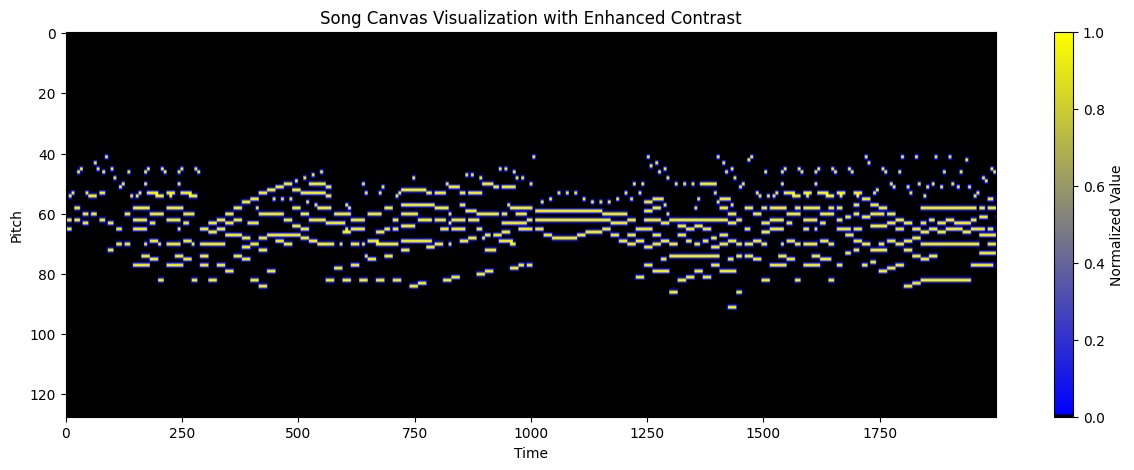

In [39]:
show_canvas(song_canvas,3,time_bounds=[0,2000])

In [32]:
mid = pretty_midi.PrettyMIDI(midi_file="F:\\Musik\\Classical Pieces\\Midi\\Mozart - Queen of the Night.mid")
tempo_times, tempo_bpm = mid.get_tempo_changes()
end_time = mid.get_end_time()
tempo_times = np.append(tempo_times, end_time)

midi_notes = []
for inst in mid.instruments:
    channel = inst.program
    for n in inst.notes:
        midi_notes.append(MIDI_note(pitch=n.pitch, time_start=n.start, time_end=n.end, dynamic=n.velocity, channel=channel))

midi_notes = list(set(midi_notes))
midi_notes = sorted(midi_notes, key=lambda note: note.time_start)

In [33]:
for inst in mid.instruments:
    print(inst.program)

73
68
70
70
60
57
47
48
48
41
1
42
43
56
